# Sumador de Draper AQFT

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
IBMQ.save_account('b6a64fd92bc0d0f5af8011f1800820500e02cfafc29bb98e2c13c746b883ffa885b544d9e0d286cac28786d034872f25f77be296e88ac9e8bef093cb659536fb')

configrc.store_credentials:WARNING:2021-04-18 00:22:28,448: Credentials already present. Set overwrite=True to overwrite.


In [10]:
def aqft_rotations(circuit):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    circuit.h(3)
    circuit.cp(pi/2**(1), 2, 3) # pasamos el numero, el qubit de control
                                            # y luego el objetivo.
    circuit.cp(pi/2**(2), 1, 3)
    
    circuit.barrier(3,2,1)
    
    circuit.h(2)
    circuit.cp(pi/2**(1), 1, 2)
    circuit.cp(pi/2**(2), 0, 2)
    circuit.barrier(2,1)
    
    circuit.h(1)
    circuit.cp(pi/2**(1), 0, 1)
    circuit.barrier(1,0)
    
    circuit.h(0)
    
    circuit.barrier(0)

In [11]:
def adder(circuit, n):
    
    circuit.cp(pi/2**(0), n  ,0)
    circuit.cp(pi/2**(1), n+1,0)
    circuit.cp(pi/2**(2), n+2,0)
    circuit.cp(pi/2**(3), n+3,0)
    circuit.barrier(range(8))
    
    circuit.cp(pi/2**(0), n+1,1)
    circuit.cp(pi/2**(1), n+2,1)
    circuit.cp(pi/2**(2), n+3,1)
    circuit.barrier(range(2*n))
   
    circuit.cp(pi/2**(0), n+2,2)
    circuit.cp(pi/2**(1), n+3,2)
    circuit.barrier(range(8))
  
    circuit.cp(pi/2**(0), n+3,3)
    
    circuit.barrier(range(8))

In [34]:
def swap_registers(circuit, n):
    for qubit in range(n//2): # tenemos que hacer el swap para queden bien 
        circuit.swap(qubit, n-qubit-1)
    return circuit

In [35]:
def aqft(circuit, n):
    """QFT on the first n qubits in circuit"""
    aqft_rotations(circuit)
    swap_registers(circuit, n)
    return circuit

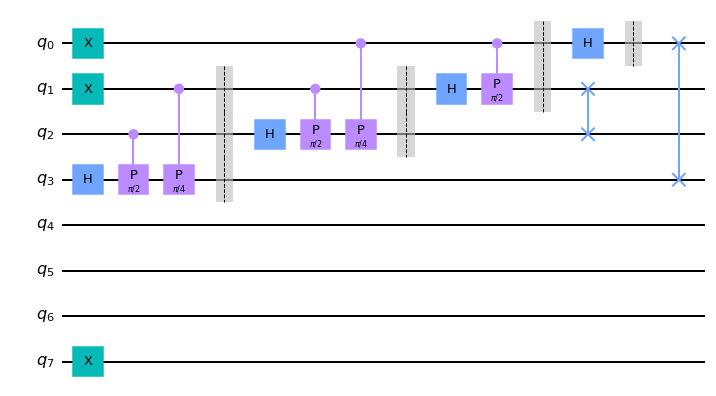

In [44]:
n = 8
nA = 4
qc = QuantumCircuit(n)

#Nuestro numero A seria |0011> (3)
qc.x(0)
qc.x(1)

#Nuestro numero B seria |1000> (1)
qc.x(7)

aqft(qc,nA)
qc.draw('mpl')

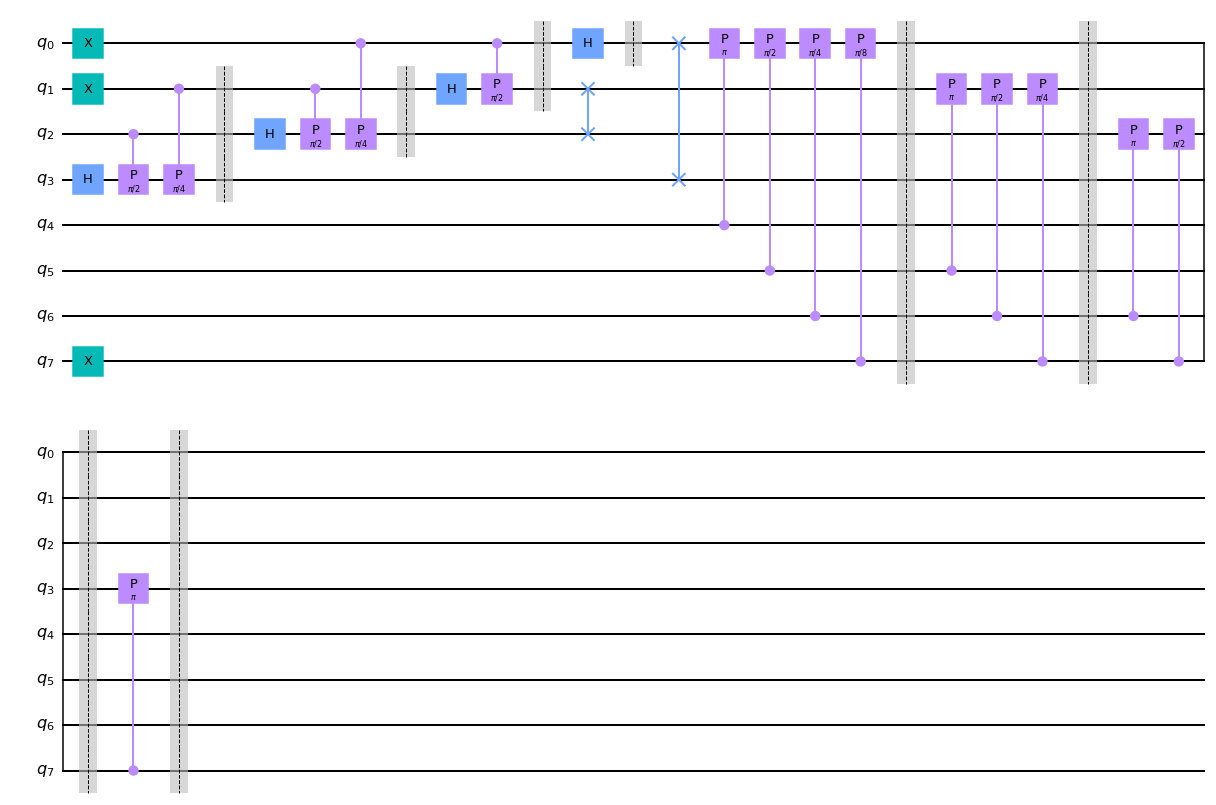

In [45]:
adder(qc,nA)
qc.draw('mpl')

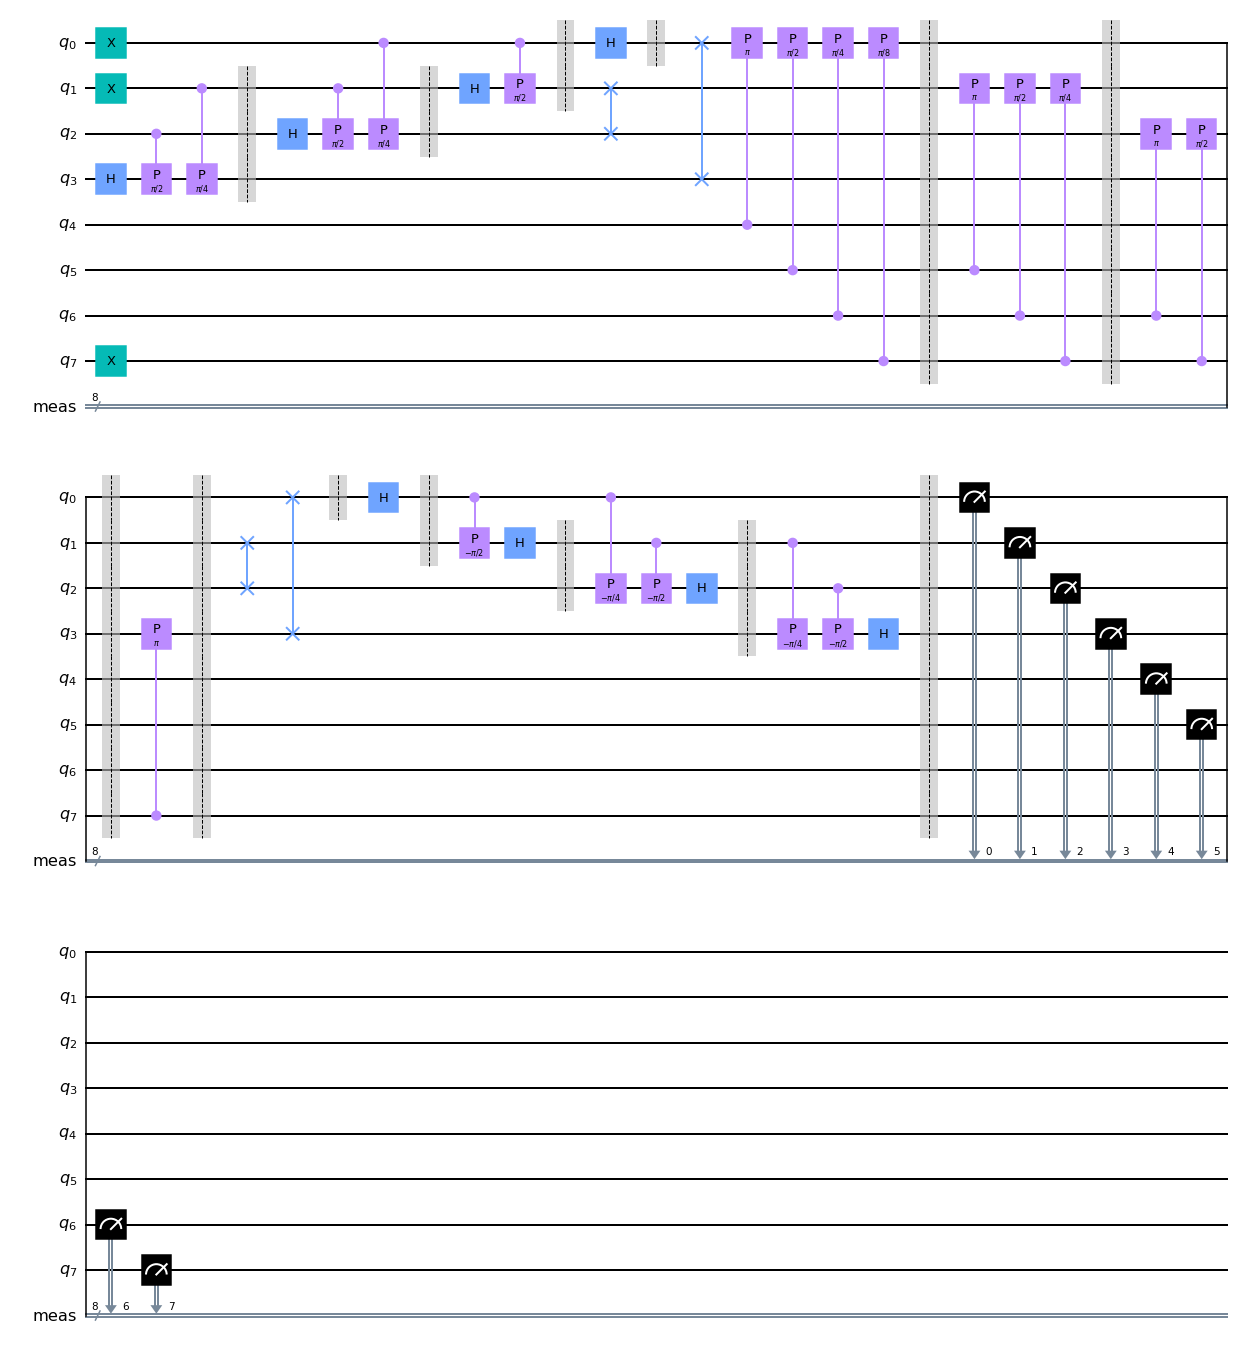

In [46]:
qc+= aqft(QuantumCircuit(n),nA).inverse()
qc.measure_all()
qc.draw('mpl')

In [47]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000)

result = job.result()

counts = result.get_counts(qc)
print("\nNúmero de ocurrencias: ",counts)


Número de ocurrencias:  {'10000100': 962, '10001100': 38}


Como vemos, hemos sumado bien los qubits, ya que 3+1 = 4, y los ultimos 4 bits menos significativos es 0100.

# Backend real

In [50]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 7 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/feynman/anaconda3/envs/qiskitEnv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_16_melbourne


In [51]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_qc, shots=shots)
job = backend.run(qobj)
job_monitor(job)

Job Status: job has successfully run


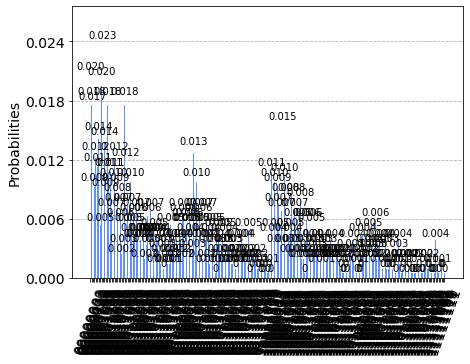

In [52]:
counts = job.result().get_counts()
plot_histogram(counts)